In [1]:
import numpy as np
import scipy as sp

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


## Make Y_0

In [2]:
# normal dist
N = 10000
mean = 75
std = 10
y_0 = np.random.normal(loc=mean, scale=std, size=N)
y_0 = np.round(y_0, 2)

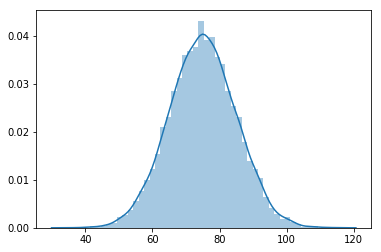

In [3]:
sns.distplot(y_0)

## Make Treatment Effect and Y_1

In [4]:
true_treatment_effect_mean = 10
true_treatment_effect = np.round(np.random.normal(loc=true_treatment_effect_mean, scale=0.1, size=N) 
                         + np.random.uniform(-true_treatment_effect_mean/20, true_treatment_effect_mean/20, size=N),2)

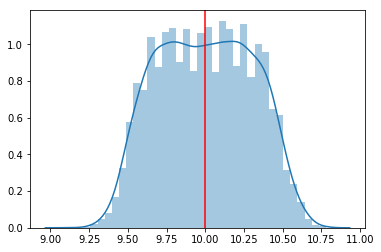

In [5]:
sns.distplot(true_treatment_effect)
plt.axvline(true_treatment_effect.mean(), color = 'r')
plt.show()

In [6]:
y_1 = y_0 + true_treatment_effect

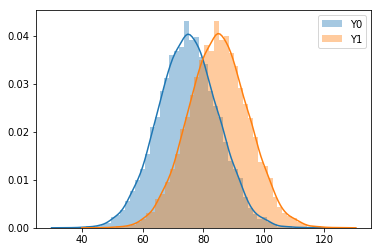

In [7]:
sns.distplot(y_0, label='Y0')
sns.distplot(y_1, label='Y1')
plt.legend()
plt.show()

## Add Never Buyers, conditional buyers, and do not disturbs

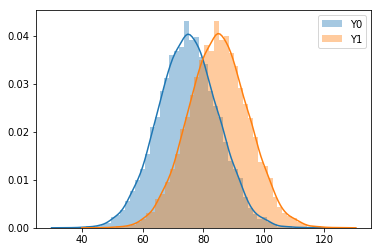

In [8]:
sns.distplot(y_0, label='Y0')
sns.distplot(y_1, label='Y1')
plt.legend()
plt.show()

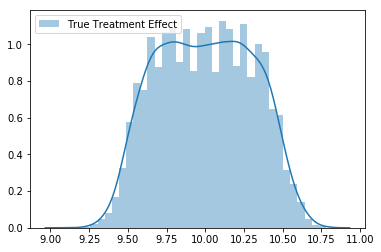

In [9]:
sns.distplot(true_treatment_effect[true_treatment_effect>0], label='True Treatment Effect')
plt.legend()
plt.show()

## END OF DAT GEN

In [10]:
price_of_treatment = 5
print('Profit when doing nothing: {}'.format(y_0.sum()))
print('Profit when targeting all: {}'.format(y_1.sum() - (price_of_treatment*N)))

Profit when doing nothing: 749678.4099999999
Profit when targeting all: 799674.34


In [11]:
true_treatment_effect_mean

10

## Classical RCT

In [13]:
rct_outcome = y_0.copy() # initialise outcome with y0
rct_indices = np.random.choice(a = np.arange(y_0.size), 
                                      size = int(y_0.size * 0.5), replace = False)
rct_outcome[rct_indices] = y_1[rct_indices]
rct_mask = np.ones_like(y_0, dtype=bool)
rct_mask[rct_indices] = False

In [14]:
#outcome
print('Estimated Treatment Effect: {}'.format(rct_outcome[~rct_mask].mean() - rct_outcome[rct_mask].mean()))
print('True Treatment Effect:      {}'.format(true_treatment_effect.mean()))
print('Profit:         {}'.format(rct_outcome.sum()))
print('Targeting none: {}'.format(y_0.sum()))
print('Targeting all:  {}'.format(y_1.sum()))

Estimated Treatment Effect: 9.982821999999999
True Treatment Effect:      9.999592999999999
Profit:         799685.3700000001
Targeting none: 749678.4099999999
Targeting all:  849674.34


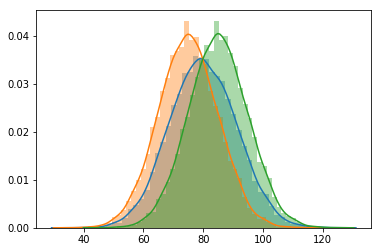

In [15]:
sns.distplot(rct_outcome)
sns.distplot(y_0)
sns.distplot(y_1)
plt.show()

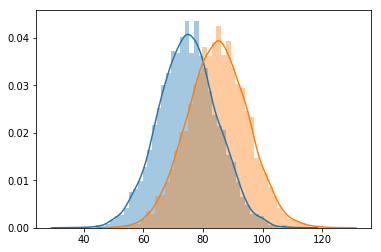

In [16]:
sns.distplot(rct_outcome[rct_mask])
sns.distplot(rct_outcome[(~rct_mask)])
plt.show()

## Imbalanced Targeting

In [17]:
imb_ratio = 0.80
imb_outcome = y_0.copy() # initialise outcome with y0
imb_indices = np.random.choice(a = np.arange(y_0.size), 
                                      size = int(y_0.size * imb_ratio), replace = False)
imb_outcome[imb_indices] = y_1[imb_indices]
imb_mask = np.ones_like(y_0, dtype=bool)
imb_mask[imb_indices] = False

In [64]:
#outcome
print('Estimated Treatment Effect: {}'.format(imb_outcome[~imb_mask].mean() - imb_outcome[imb_mask].mean()))
print('True Treatment Effect:      {}'.format(true_treatment_effect.mean()))
print('Profit:         {}'.format(imb_outcome.sum()))
print('Targeting none: {}'.format(y_0.sum()))
print('Targeting all:  {}'.format(y_1.sum()))

Estimated Treatment Effect: 10.506706250000022
True Treatment Effect:      9.999592999999999
Profit:         829682.95
Targeting none: 749678.4099999999
Targeting all:  849674.34


# Propensity Score Weighting

### 'Uplift' Model
To assign propensity scores, we need an uplift model.
Here we simulate having one by adding noise to our true effect
t_hat = t_true + gaussian noise + sin noise + uniform noise + bias

In [19]:
bias = -1
pred_uplift = np.round(true_treatment_effect 
                       + np.random.normal(loc = 0, scale=true_treatment_effect_mean/50,size=N)
                       + np.random.uniform(-true_treatment_effect_mean/50, true_treatment_effect_mean/50, size=N)
                       + bias
                       ,2)
pred_uplift = np.where(pred_uplift<0, 0, pred_uplift)

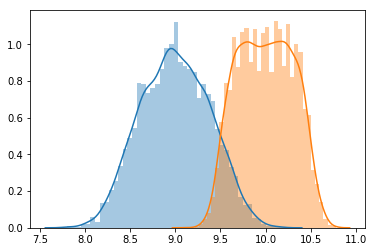

In [20]:
sns.distplot(pred_uplift, label='Uplift Model')
sns.distplot(true_treatment_effect, label='True')
plt.show()

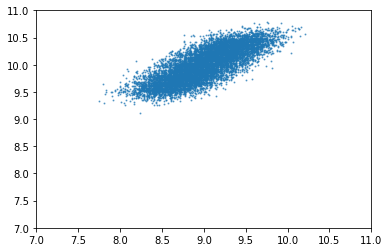

In [27]:
plt.scatter(x=pred_uplift, y=true_treatment_effect, s=1, alpha = 0.6)
plt.xlim(7,11)
plt.ylim(7,11)
plt.show()

In [28]:
sp.stats.pearsonr(pred_uplift, true_treatment_effect)

(0.7944139471688814, 0.0)

In [29]:
pred_uplift.mean()

8.999254

In [30]:
true_treatment_effect.mean()

9.999592999999999

### Bad naive RCT
Targeting top 50% according to uplift model

### Assigning Propensity Scores
Min max scale to [0,1]

In [37]:
assigned_prop_scores = (pred_uplift-pred_uplift.min())/(pred_uplift.max()-pred_uplift.min())

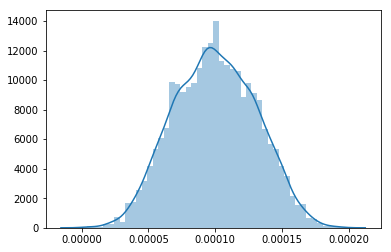

0.5078268292682926 It works, I swear.


In [59]:
sns.distplot(assigned_prop_scores/assigned_prop_scores.sum())
# plt.axvline(assigned_prop_scores.mean())
plt.show()
print(assigned_prop_scores.mean(),'It works, I swear.')

### Assign Treatment based on prop score
Prop Score Targeting (PST)

In [87]:
pst_ratio=0.8
pst_indices = np.random.choice(np.arange(y_0.size), size=int(N*pst_ratio), replace=False, p=assigned_prop_scores/assigned_prop_scores.sum())

In [88]:
pst_outcome = y_0.copy()
pst_outcome[pst_indices] = y_1[pst_indices]
pst_mask = np.ones_like(y_0, dtype=bool)
pst_mask[pst_indices] = False

In [89]:
#outcome
print('Estimated Treatment Effect: {}'.format(pst_outcome[~pst_mask].mean() - pst_outcome[pst_mask].mean()))
print('True Treatment Effect:      {}'.format(true_treatment_effect.mean()))
print('Profit:         {}'.format(pst_outcome.sum()))
print('Targeting none: {}'.format(y_0.sum()))
print('Targeting all:  {}'.format(y_1.sum()))

Estimated Treatment Effect: 10.154588750000002
True Treatment Effect:      9.999592999999999
Profit:         829928.06
Targeting none: 749678.4099999999
Targeting all:  849674.34


In [90]:
rct_outcome

array([93.26, 74.33, 86.43, ..., 93.58, 80.54, 76.79])

In [91]:
#outcome
print('PST estimated ATE: {}'.format(pst_outcome[~pst_mask].mean() - pst_outcome[pst_mask].mean()))
print('IMB estimated ATE: {}'.format(imb_outcome[~imb_mask].mean() - imb_outcome[imb_mask].mean()))
print('RCT estimated ATE: {}'.format(rct_outcome[~rct_mask].mean() - rct_outcome[rct_mask].mean()))
print('True ATE:          {}'.format(true_treatment_effect.mean()))
print('')
print('Targeting none: {}'.format(y_0.sum()))
print('Profit PST:     {}'.format(pst_outcome.sum() - (0.5*N*price_of_treatment)))
print('Profit IMB:     {}'.format(imb_outcome.sum()-(imb_ratio*N*price_of_treatment)))
print('Profit RCT:     {}'.format(rct_outcome.sum()-(0.5*N*price_of_treatment)))
print('Targeting all:  {}'.format(y_1.sum()- (1*N*price_of_treatment)))

PST estimated ATE: 10.154588750000002
IMB estimated ATE: 10.506706250000022
RCT estimated ATE: 9.982821999999999
True ATE:          9.999592999999999

Targeting none: 749678.4099999999
Profit PST:     804928.06
Profit IMB:     789682.95
Profit RCT:     774685.3700000001
Targeting all:  799674.34
